In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from geopy.distance import geodesic
pd.set_option('display.max_columns', None)

In [3]:
# getting the published empty flats of Zurich in a 10km radius
result_list = []
max = 38 #number of web pages to scrape

for i in range(max):
    url = 'https://www.immoscout24.ch/de/wohnung/mieten/ort-luzern?pn={}&r=10'.format(i+1)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw_data = soup.find(id='state')
    jason_data = json.loads(raw_data.string.replace('undefined', 'null')[18:])
    data_list = jason_data['pages']['searchResult']['resultData']['listData']

    page_list = []

    for elem in data_list:
        if 'price' in elem: price = elem['price']
        else: price = np.nan

        if 'surfaceLiving' in elem: sl = elem['surfaceLiving']
        else: sl = np.nan

        if 'numberOfRooms' in elem: nor = elem['numberOfRooms']
        else: nor = np.nan

        if 'title' in elem: ttl = elem['title']
        else: ttl = np.nan

        if 'latitude' in elem: lat = elem['latitude']
        else: lat = np.nan

        if 'longitude' in elem: lon = elem['longitude']
        else: lon = np.nan

        page_list.append([elem['id'], price, nor, sl, ttl, elem['zip'], lat, lon])

    result_list += page_list

result_list[10:12]

[[6101380,
  1725,
  2.5,
  48,
  'Moderne und Helle Stadtwohnung mit eigenem Gartensitzplatz',
  '6014',
  47.06496,
  8.28089],
 [6116343,
  1850,
  3.5,
  100,
  '3.5 Zimmer-Dachwohnung auf gepflegten Bauernhof mit Panoramasicht',
  '6034',
  47.12742,
  8.36099]]

In [13]:
flats_df = pd.DataFrame(result_list)
flats_df.columns = ['ID', 'Price', 'RoomNr', 'Surface', 'Title', 'ZIP', 'Latitude', 'Longitude']

flats_df.dropna(inplace=True)
flats_df['Title'] = flats_df['Title'].str.lower()

flats_df['Vista'] = 0
filter1 = flats_df['Title'].str.contains('blick|sicht|anstoss')
filter2 = ~flats_df['Title'].str.contains('besichtigung')
flats_df.loc[filter1 & filter2, 'Vista'] = 1

#flats_df['Bright'] = 0
#filter3 = flats_df['Title'].str.contains("hell|licht|sonnig")
#flats_df.loc[filter3, 'Bright'] = 1

flats_df['New'] = 0
filter4 = flats_df['Title'].str.contains("neu|new")
flats_df.loc[filter4, 'New'] = 1

#flats_df['Furnished'] = 0
#filter5 = flats_df['Title'].str.contains("möbliert")
#flats_df.loc[filter5, 'Furnished'] = 1

#flats_df['Vista'].value_counts()
flats_df.corr()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,New
ID,1.000000,0.054013,-0.002898,-0.011393,0.015983,0.071210,0.063157,-0.005796
Price,0.054013,1.000000,0.417246,0.588601,-0.095047,0.155711,0.127688,-0.042979
RoomNr,-0.002898,0.417246,1.000000,0.797370,0.082935,0.056979,0.127495,-0.013309
Surface,-0.011393,0.588601,0.797370,1.000000,0.012587,0.105916,0.185422,-0.019977
Latitude,0.015983,-0.095047,0.082935,0.012587,1.000000,0.034711,-0.056163,-0.027824
Longitude,0.071210,0.155711,0.056979,0.105916,0.034711,1.000000,0.119626,-0.063779
Vista,0.063157,0.127688,0.127495,0.185422,-0.056163,0.119626,1.000000,-0.039723
New,-0.005796,-0.042979,-0.013309,-0.019977,-0.027824,-0.063779,-0.039723,1.000000


In [15]:
#Adding each flats distance to the Lucerne Main Station

distance_list = []
for id, lat, lon in zip(flats_df['ID'], flats_df['Latitude'], flats_df['Longitude']):
    distance_list.append(geodesic((lat,lon), (47.050481,8.309427)).kilometers)

flats_df['StationDist'] = pd.DataFrame(distance_list)
flats_df.dropna(inplace=True)
flats_df.corr()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,New,StationDist
ID,1.000000,0.069595,-0.011367,0.001781,-0.043281,0.129036,0.050446,-0.010137,0.039971
Price,0.069595,1.000000,0.499499,0.698425,-0.063478,0.084297,0.041994,-0.054870,0.091999
RoomNr,-0.011367,0.499499,1.000000,0.788360,0.136867,-0.019472,0.069242,-0.024827,0.054710
Surface,0.001781,0.698425,0.788360,1.000000,0.111054,-0.011007,0.076764,-0.037894,0.077278
Latitude,-0.043281,-0.063478,0.136867,0.111054,1.000000,0.052220,-0.024521,-0.016025,0.099826
Longitude,0.129036,0.084297,-0.019472,-0.011007,0.052220,1.000000,0.130925,-0.059598,-0.039128
Vista,0.050446,0.041994,0.069242,0.076764,-0.024521,0.130925,1.000000,-0.034421,-0.014949
New,-0.010137,-0.054870,-0.024827,-0.037894,-0.016025,-0.059598,-0.034421,1.000000,-0.016715
StationDist,0.039971,0.091999,0.054710,0.077278,0.099826,-0.039128,-0.014949,-0.016715,1.000000


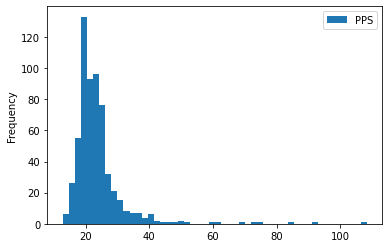

In [21]:
#Calculating price per squaremeter
pps = flats_df['Price'] / flats_df['Surface']
flats_df['PPS'] = pps
flats_df = flats_df[flats_df['PPS']<1400]
flats_df[['PPS']].plot.hist(bins=50)

In [25]:
flats_df = flats_df[flats_df['PPS']<60]
flats_df.corr()

,ID,Price,RoomNr,Surface,Latitude,Longitude,Vista,New,StationDist,PPS
ID,1.000000,0.072974,-0.001373,0.014202,-0.043542,0.128546,0.051881,-0.008563,0.040130,0.010903
Price,0.072974,1.000000,0.499416,0.711211,-0.064698,0.085983,0.039833,-0.058645,0.083940,-0.063799
RoomNr,-0.001373,0.499416,1.000000,0.778387,0.139777,-0.014154,0.063354,-0.035391,0.054556,-0.619085
Surface,0.014202,0.711211,0.778387,1.000000,0.118587,-0.009142,0.070144,-0.051815,0.076990,-0.681920
Latitude,-0.043542,-0.064698,0.139777,0.118587,1.000000,0.053423,-0.024408,-0.015878,0.099642,-0.211037
Longitude,0.128546,0.085983,-0.014154,-0.009142,0.053423,1.000000,0.131540,-0.059236,-0.039802,0.087670
Vista,0.051881,0.039833,0.063354,0.070144,-0.024408,0.131540,1.000000,-0.035769,-0.015406,-0.066528
New,-0.008563,-0.058645,-0.035391,-0.051815,-0.015878,-0.059236,-0.035769,1.000000,-0.017247,0.007571
StationDist,0.040130,0.083940,0.054556,0.076990,0.099642,-0.039802,-0.015406,-0.017247,1.000000,-0.035323
PPS,0.010903,-0.063799,-0.619085,-0.681920,-0.211037,0.087670,-0.066528,0.007571,-0.035323,1.000000


In [28]:
# create map of Lucerne using latitude and longitude values
map_lucerne = folium.Map(location=[47.050481,8.309427], zoom_start=11.5)

linear = cm.LinearColormap(
    ['blue', 'green', 'red'],
    vmin=0, vmax=60
)

linear

# add markers to map
for lat, lng, price, pps in zip(flats_df['Latitude'], flats_df['Longitude'], flats_df['Price'], flats_df['PPS']):
    label = folium.Popup(str(pps), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=linear(pps),
        fill=True,
        fill_color=linear(pps),
        fill_opacity=0.7,
        parse_html=False).add_to(map_lucerne)

map_lucerne